In [35]:
import numpy as np
from bposd.hgp import hgp
from bposd.css_decode_sim import css_decode_sim
from quantum_code import *
import matplotlib.pyplot as plt
from classical_code import *
from ldpc import bposd_decoder, bp_decoder
import galois
from numpy.linalg import matrix_power, matrix_rank
from bposd.css import css_code

In [32]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [6,9,3,1,2,3,1,2],
    [12,6,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[0]

def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

qcode = css_code(Hx, Hz)
# xL, zL = qcode.compute_logicals()
# k = xL.shape[0]

# for l in xL:
#     print(np.where(l)[0])

# n = Hx.shape[1]
# Hx_inds = [np.where(Hx[i])[0] for i in range(Hx.shape[0])]
# Hz_inds = [np.where(Hz[i])[0] for i in range(Hz.shape[0])]

# k, Hx_inds, Hz_inds, xL_inds, zL_inds = format_qcode(Hx, Hz)

# qcode = QuantumCode(n, k, Hx.shape[0], Hz.shape[0],
#                     0, 0,
#                     Hx_inds, Hz_inds, xL_inds, zL_inds)
# write_qcode("../codes/qcodes" + f"/BB_{n}_{k}.qcode", qcode)

In [34]:
osd_options={
'error_rate': 0.03,
'target_runs': 10000,
'xyz_error_bias': [0, 0, 1],
'output_file': 'test.json',
'max_iter': qcode.hx.shape[1],
'bp_method': "msl",
'ms_scaling_factor': 0,
'osd_method': "osd0",
'osd_order': 0,
'channel_update': None,
'seed': 42,
'max_iter': 0,
'output_file': "test.json"
}

lk = css_decode_sim(hx=Hx, hz=Hz, **osd_options)

RNG Seed: 42
Constructing CSS code from hx and hz matrices...
Checking the CSS code is valid...
<Unnamed CSS code>, (3,6)-[[72,12,nan]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (3,6)-[[72,12,nan]]


d_max: 6; OSDW_WER: 0.313±0.016%; OSDW: 3.69±0.19%; OSD0: 3.69±0.19%;: 100% 10000/10000 [00:07<00:00, 1395.02it/s]


In [109]:
qubit_error_rate = 0.01
qcode_hgp = read_qcode("../codes/qcodes/HGP_100_4.qcode")
Hx, Hz, Lx, Lz = qcode_hgp.to_numpy()

bposd_qec_dec = bposd_decoder(
    Hx[qcode_hgp.qedxm:],
    error_rate=qubit_error_rate,
    bp_method="msl",
    max_iter=Hx.shape[1],
    ms_scaling_factor=0,
    osd_method="osd0",
    # osd_order=40
)

In [117]:
GF = galois.GF(2)
ccode = read_code("../codes/ccodes/16_12_3_4.code")
H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1
dim0, dim1 = H.shape
print(H)
print(dim1 - np.linalg.matrix_rank(GF(H)))

[[1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0]]
4


In [118]:
qcode=hgp(H, compute_distance=True)
qcode.print_code_parameters()
qcode.compute_ldpc_params()
for l in qcode.lz:
    print(np.where(l)[0])

[[400,16,6]]
[ 16  32  64 128 144 160 176 192]
[ 17  33  65 129 145 161 177 193]
[ 18  34  66 130 146 162 178 194]
[ 20  36  68 132 148 164 180 196]
[ 16  32  96 144 176 208]
[ 17  33  97 145 177 209]
[ 18  34  98 146 178 210]
[ 20  36 100 148 180 212]
[  0  16  64 112 176 224]
[  1  17  65 113 177 225]
[  2  18  66 114 178 226]
[  4  20  68 116 180 228]
[ 32  48  64  80 144 240]
[ 33  49  65  81 145 241]
[ 34  50  66  82 146 242]
[ 36  52  68  84 148 244]


In [112]:
for l in qcode.lx:
    print(np.where(l)[0])

[ 8 10 11 12]
[32 34 35 36]
[33 37 38 39]
[49 53 54 55]


In [76]:

osd_options={
'error_rate': 0.01,
'target_runs': 10000,
'xyz_error_bias': [0, 0, 1],
'output_file': 'test.json',
'max_iter': qcode.hx.shape[1],
'bp_method': "msl",
'ms_scaling_factor': 0,
'osd_method': "osd0",
'osd_order': 0,
'channel_update': None,
'seed': 42,
'max_iter': 0,
'output_file': "test.json"
}

lk = css_decode_sim(hx=Hx, hz=Hz, **osd_options)

RNG Seed: 42
Constructing CSS code from hx and hz matrices...
Checking the CSS code is valid...
<Unnamed CSS code>, (4,7)-[[100,4,nan]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (4,7)-[[100,4,nan]]


d_max: 4; OSDW_WER: 0.253±0.025%; OSDW: 1.01±0.1%; OSD0: 1.01±0.1%;: 100% 10000/10000 [00:07<00:00, 1337.86it/s]   


In [42]:
from math import comb

def prob(n, p):
    p_sum = 0
    for k in range(n//2):
        p_sum += comb(n, 2*k+1) * p**(2*k+1) * (1-p)**(n-(2*k+1))
    return p_sum

prob(16, 1e-3)

0.015762225509632473

In [85]:
deltaV = 12
deltaC = 14

n = 4
p = 0.001

num_non_adaptive_CNOTs = []
num_adaptive_CNOTs = []
iss = []

for i in range(100, 10000):
    if (i % (n-2) == 0):
        iss.append(i)
        num_non_adaptive_CNOTs.append(i * deltaV)

        expected_CNOTs = (i // (n-2)) * prob(n, p) * (n * deltaV) * deltaC
        expected_CNOTs += (i // (n-2)) * n
        num_adaptive_CNOTs.append(expected_CNOTs)

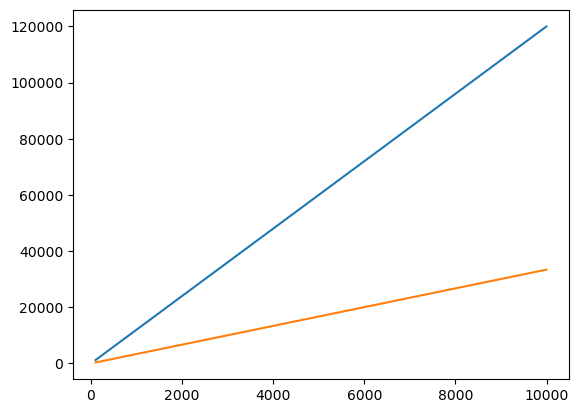

In [86]:
plt.plot(iss, num_non_adaptive_CNOTs)
plt.plot(iss, num_adaptive_CNOTs)
